# Importing packges

## QCoDeS and equipment drivers

In [1]:
%matplotlib notebook

import os
import sys 
import time
import datetime

from collections import OrderedDict
from importlib import reload

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython.display import clear_output

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430, AMI430_3D
from qcodes.instrument_drivers.Lakeshore import Model_372

from pytopo.qctools import instruments as instools

In [2]:
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

In [3]:
sys.path.append(r"D:\OneDrive\BF3\Code")  # we do this dirt only for "v2_dataset_tools" package to be on path

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [4]:
sys.path.append(r"D:\OneDrive\BF3\Code\characterizations\characterizations")

In [5]:
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC

## Initialize Qcodes database

In [6]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists


In [7]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]  # instead of this, get_DB_location function can be used :)
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "D:/Data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

## hdf5 file format conversion

In [8]:
sys.path.append(r"D:\OneDrive\BF3\Code\utils")

import utils
from utils import dic_data
from utils.dic_data import dic2hdf5, data

In [9]:
dat = data.init_dic_data('Lucas awesome measurement')
dat['data'] = {'current': s.get_data('current')}
dic2hdf5.save_dict_to_hdf5(dat, dat['filepath'])
dic2hdf5.load_dict_from_hdf5

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\data\\20180830'

## Convert PCB numbering to break-out box

In [9]:
sys.path.append(r"D:\OneDrive\BF3\Code\BF3")
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [10]:
Gen5_to_BoB(87)

pad 87 is matrix element(2, 19)


[(2, 19)]

# Initializing and checking equipments

## MDAC

In [11]:
mdac = MDAC('MDAC1', 'ASRL5::INSTR', debug=False, logging=False)

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040028003E, firmware:1.4) in 3.38s


In [12]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]
def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)

def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')


## Lock-ins

In [13]:
sr1 = SR860("sr1", "GPIB0::4::INSTR")
sr1.amplitude.vals._min_value = 0

Connected to: Stanford_Research_Systems SR860 (serial:003223, firmware:V1.47) in 0.17s


In [14]:
sr2 = SR860("sr2", "TCPIP0::192.168.0.170::INSTR")
sr2.amplitude.vals._min_value = 0

Connected to: Stanford_Research_Systems SR860 (serial:003214, firmware:V1.47) in 0.15s


In [15]:
print('lockin1 excitation amplitude =', sr1.amplitude(), 'V')
print('lockin1 DC bias =', sr1.sine_outdc(), 'V')
print('lockin1 frequency =', sr1.frequency(), 'Hz')
print('lockin1 phase =', sr1.phase(), 'deg')
print('lockin1 X =', sr1.X(), 'V')
print('lockin1 Y =', sr1.Y(), 'V')
print('lockin1 R =', sr1.R(), 'V')
print('lockin1 P =', sr1.P(), 'deg')


lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = 0.0 V
lockin1 frequency = 117.0 Hz
lockin1 phase = 0.0 deg
lockin1 X = 4.5548658818e-06 V
lockin1 Y = 1.8998981943e-08 V
lockin1 R = 4.4177782001e-06 V
lockin1 P = 1.1262179613 deg


In [16]:
print('lockin2 excitation amplitude =', sr2.amplitude(), 'V')
print('lockin2 DC bias =', sr2.sine_outdc(), 'V')
print('lockin2 frequency =', sr2.frequency(), 'Hz')
print('lockin2 phase =', sr2.phase(), 'deg')
print('lockin2 X =', sr2.X(), 'V')
print('lockin2 Y =', sr2.Y(), 'V')
print('lockin2 R =', sr2.R(), 'V')
print('lockin2 P =', sr2.P(), 'deg')


lockin2 excitation amplitude = 0.0 V
lockin2 DC bias = 0.0 V
lockin2 frequency = 117.0 Hz
lockin2 phase = 0.0 deg
lockin2 X = 2.6858972433e-06 V
lockin2 Y = 1.5965291595e-06 V
lockin2 R = 3.2599939459e-06 V
lockin2 P = 25.522323608 deg


In [17]:
sr1.amplitude()

0.0019999998622

In [17]:
set_mdac_in_safemode() 

setting mdac in safe mode
Done


## Keysight DMMs

In [18]:
key1 = Keysight_34465A("key1", "TCPIP0::192.168.0.150")

Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.98s


In [19]:
key2 = Keysight_34465A("key2", "TCPIP0::192.168.0.151")

Connected to: Keysight Technologies 34465A (serial:MY57505146, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.59s


In [ ]:
key1 = qc.find_or_create_instrument(Keysight_34465A, "key1", recreate=True, address="TCPIP0::192.168.0.150")

In [80]:
key2 = qc.find_or_create_instrument(Keysight_34465A, "key2", recreate=True, address="TCPIP0::192.168.0.151")

Connected to: Keysight Technologies 34465A (serial:MY57505146, firmware:A.02.16-02.40-02.16-00.51-03-01) in 1.48s


In [ ]:
key1.ask('TRIG:COUN?')

In [24]:
#%%timeit
key2.write('INIT')
#ami_x.field()
key2.ask('FETC?')
#key1.ask('DATA:LAST?')

'+9.79213770E-05'

In [25]:
key2.NPLC(1)
key2.write('TRIG:COUN INF')

In [26]:
#%%timeit
key2.ask('TRIG:COUN?')

'9.9E37'

In [ ]:
key2.write('CONF:VOLT:DC')
key2.write('SAMP:COUN 200')
key2.write('TRIG:COUN 1')

time.sleep(10);

kV = key2.ask('READ?')

plt.plot(range(len(kV)), kV);

In [ ]:
k1_R_vals = np.empty

In [39]:
timer = time.time()
for i in range(100):
    key1.volt()
    key2.volt()
    
timer = time.time() - timer
print(timer/100)

0.13768250942230226


## IVVI rack

In [20]:
ivvi = IVVI("ivvi", 'ASRL4::INSTR')

Initialized IVVI-rack in 0.03s


In [21]:
ivvi.set_dacs_zero()

In [34]:
ivvi.get_all()

{'__class__': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
 'address': 'ASRL4::INSTR',
 'functions': {'trigger': {}},
 'name': 'ivvi',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'ivvi_IDN',
   'instrument': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
   'instrument_name': 'ivvi',
   'inter_delay': 0,
   'label': 'IDN',
   'name': 'IDN',
   'post_delay': 0,
   'raw_value': -1,
   'ts': '2018-08-30 13:21:04',
   'unit': '',
   'vals': '<Anything>',
   'value': -1},
  'check_setpoints': {'__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'ivvi_check_setpoints',
   'instrument': 'qcodes.instrument_drivers.QuTech.IVVI.IVVI',
   'instrument_name': 'ivvi',
   'inter_delay': 0,
   'label': 'Check setpoints',
   'name': 'check_setpoints',
   'post_delay': 0,
   'raw_value': False,
   'ts': '2018-08-30 13:21:04',
   'unit': '',
   'vals': '<Boolean>',
   'value': False},
  'dac1': {'__class__': 'qcodes.instrument.parameter.

## Yokogawa source

In [20]:
yoko2 = GS200("yoko2", "GPIB0::2::INSTR")

Connected to: YOKOGAWA GS210 (serial:91T926460, firmware:2.02) in 0.02s


In [21]:
yoko2.voltage()

0.0

## AMI Magnets

In [22]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "192.168.0.157", port = 7180, has_current_rating=True)
ami_y = instools.create_inst(AMI430, "AMI430_y", "192.168.0.158", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "192.168.0.159", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1802*ramp_limit_multiplier)
ami_x.coil_constant(0.01466)
ami_x.current_rating(68.21)

ami_y.current_ramp_limit(0.1784*ramp_limit_multiplier)
ami_y.coil_constant(0.01464)
ami_y.current_rating(68.31)

ami_z.current_ramp_limit(0.0775*ramp_limit_multiplier)
ami_z.coil_constant(0.0818)
ami_z.current_rating(73.35)

ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)


Connected to: AMERICAN MAGNETICS INC. 430 (serial:170074, firmware:2.55) in 0.88s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170075, firmware:2.55) in 0.84s
Connected to: AMERICAN MAGNETICS INC. 430 (serial:170076, firmware:2.55) in 1.08s


d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\american_magnetics\AMI430.py:407: AMI430Warning: Increasing maximum ramp rate: we have a default current ramp rate limit of 0.06 A/s. We do not want to ramp faster than a set maximum so as to avoid quenching the magnet. A value of 0.06 A/s seems like a safe, conservative value for any magnet. Change this value at your own responsibility after consulting the specs of your particular magnet
  warn(warning_message, category=AMI430Warning)


In [23]:
print(ami_x.ramp_rate())
print(ami_y.ramp_rate())
print(ami_z.ramp_rate())

0.001
0.0005
0.001


In [24]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())

-0.1908385
4.6e-06
-1.31e-05


## $B$ field ramp to setpoint + monitor

<IPython.core.display.Javascript object>


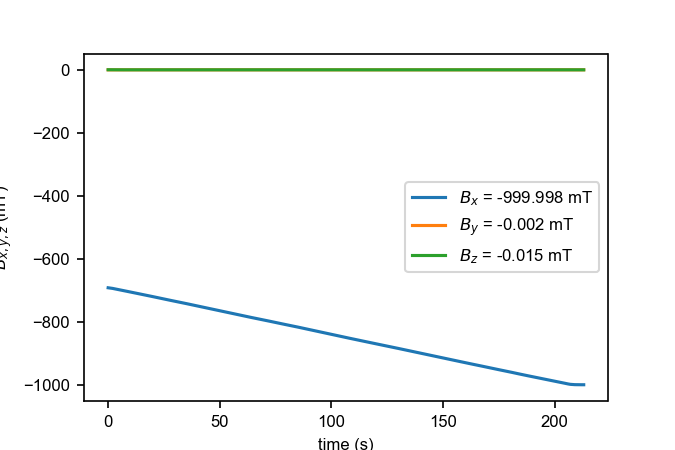

In [36]:
x_setpoint = -1000E-3; # T
y_setpoint = 0E-3; # T
z_setpoint = 0E-3; # T

fig = plt.figure('set B');
fig.clear();
fpl = fig.add_subplot(1, 1, 1);

Bx, By, Bz = [], [], [];
eps = 1E-5; # T

ami_x.ramp_rate(0.001); # T/s
ami_y.ramp_rate(0.0005); # T/s
ami_z.ramp_rate(0.001); # T/s

ami_x.ramp_to(x_setpoint);
ami_y.ramp_to(y_setpoint);
ami_z.ramp_to(z_setpoint);

while np.abs(x_setpoint - ami_x.field()) > eps or np.abs(y_setpoint - ami_y.field()) > eps or np.abs(z_setpoint - ami_z.field()) > eps:
    
    Bx.append(ami_x.field());
    By.append(ami_y.field());
    Bz.append(ami_z.field());
    
    fpl.clear();
    fpl.plot(range(0, len(Bx)), np.array(Bx) * 1E3, range(0, len(By)), np.array(By)*1E3, range(0, len(Bz)), np.array(Bz)*1E3);
    fpl.legend(('$B_x$ = {} mT'.format(str(round(Bx[-1]*1E3, 3))), '$B_y$ = {} mT'.format(str(round(By[-1]*1E3, 3))), '$B_z$ = {} mT'.format(str(round(Bz[-1]*1E3, 3)))));
    plt.xlabel('time (s)');
    plt.ylabel('$B_{x,y,z}$ (mT)');
    fig.canvas.draw();
    
    time.sleep(1);

## Setters, getters, gate ramp functions

In [28]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]
def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')


In [29]:
@getter([('raw_voltage', 'V'), ('current', 'A')]) #,('V_meas', 'V')
def measure_dc_only(gain=1e7):
    time.sleep(0.03) # * key.NPLC()) 
    key_raw = key1.volt()
    #key_raw2 = key2.volt()
    current = -key_raw/gain
    #V_meas = key2.volt()
    result = key_raw, current  #, V_meas
    return result


#('B_x', 'T'), 

In [30]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]

@setter([("mdac_gate_voltage", "V")])
def mdac_gate_voltage(voltage): 
    #voltage *= 790
    ramp(gate.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

    

bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]

@setter([("mdac_bias_voltage", "V")])
def mdac_bias_voltage(voltage): 
    voltage *= 790
    ramp(source.voltage, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter([("lockin_dc", "V")])
def lockin_dc(voltage): 
    voltage *= 100
    ramp(sr1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)



@setter([("yoko2_voltage", "V")])
def yoko2_voltage(voltage): 
    #voltage *= 790
    ramp(yoko2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter([("time_sweep", "a.u.")])
def time_sweep(a): 
    time.sleep(0.001)
    
@setter([("field_sweep", "T")])
def field_sweep(a):
    time.sleep(0.001);

In [31]:
def initialize(s,g):
    ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    s.smc('close')
    s.dac_output('close')
    #d.gnd('close')
    g.dac_output('close')
    g.smc('close')

# Actual measurements

## Defining soure, drain, gate channels

In [32]:
sources = [mdac.ch58]
gate = mdac.ch09

In [26]:
source = mdac.ch58
gate = mdac.ch09

## DC only, V bias

In [ ]:
mdac_gate_voltage(1)

In [30]:
sr1.sine_outdc(0)

In [ ]:
vals = np.linspace(1,-1,401)
gate_points = np.append(vals,vals[::-1])

In [ ]:
for source in sources:
    def setup():
        #set_mdac_in_safemode()
        initialize(source, gate)
        #mdac.ch57.voltage(0)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        key1.NPLC(1)
        #source.voltage(1e-3)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr.amplitude(5e-5)     #bias AC voltage
        #sr.frequency(7)
        #sr1.phase(168.5)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_y.field(0)

    def cleanup(): 
        #pass
        set_mdac_in_safemode()
        #sr.amplitude(0)
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q0163_D15D14_gate_leak_test",
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 0.4, 64)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(yoko2_voltage, np.linspace(0, -10, 11)),
            #sweep(mdac_gate_voltage, np.linspace(0, -3, 201)),
            sweep(mdac_gate_voltage, np.linspace(0,3, 300)),
            #sweep(mdac_bias_voltage, np.linspace(10e-3,-10e-3,101)),  
            measure_dc_only
        ),
        [(cleanup, ())],
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=[{"Gate ": 0, "Current": 2}]
    )

## DC + lockin, V bias

In [32]:
initialize(source,gate)

In [33]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [70]:
gate.voltage()

0.0

In [35]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(1)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

gate_values = np.linspace(1, -0.3, 101)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_A19A21_pinchoff_check",
    [(setup, ())],
    nest(       
        #sweep(ami_z.field, np.linspace(0, 5.5, 55)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
#         sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes= None
)

setting mdac in safe mode
Done
Starting experimental run with id: 154
setting mdac in safe mode
Done
Completed measurement. Database path: Q169_A19A21_pinchoff_check/1


In [161]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0.24)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    sr1.phase(180)
    #sr1.time_constant(.1)
    ami_x.field(-1)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')]) #, ('B_x', 'T')
def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
    time.sleep(0.01)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac #, B_x
    return result

#gate_values = np.linspace(1, -0.3, 101)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_B15B13_AB_120mK_largeBsweep_Vg=0.24_checkSetField",
    [(setup, ())],
    nest(       
        sweep(ami_x.field, np.linspace(-1, 1, 13010)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(field_sweep, field_window(ami_x, -1, 1)),
        #sweep(mdac_gate_voltage, gate_values),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes= None
)

setting mdac in safe mode
Done
Starting experimental run with id: 111
setting mdac in safe mode


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


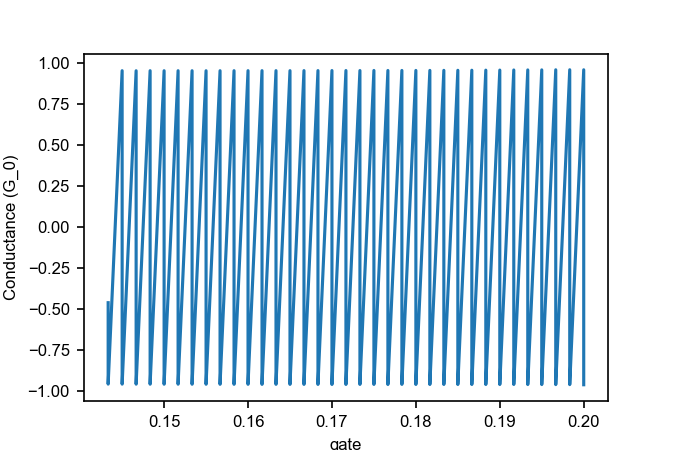

setting mdac in safe mode
Done
Starting experimental run with id: 949


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.2, right=0.2
  'left=%s, right=%s') % (left, right))


setting mdac in safe mode
Done


KeyboardInterrupt: 

In [47]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0.2)
    lockin_dc(15e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(1, -0.5, 201)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_D6D3_QPC_gate_bias",
    [(setup, ())],
    nest(       
        #sweep(ami_z.field, np.linspace(5.5, 0, 56)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(15e-3, -15e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(0.2, -0.3, 301)),
        sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"gate": 0, "Conductance (G_0)": 3}]
)

In [45]:
print(ami_x.field())
print(ami_y.field())
print(ami_z.field())

3.3e-06
-4.7e-06
-2.24e-05


## Measure while ramping $B$

In [44]:
initialize(source, gate)

In [65]:
mdac_gate_voltage(0.2)  

{'mdac_gate_voltage': 0.2}

<IPython.core.display.Javascript object>


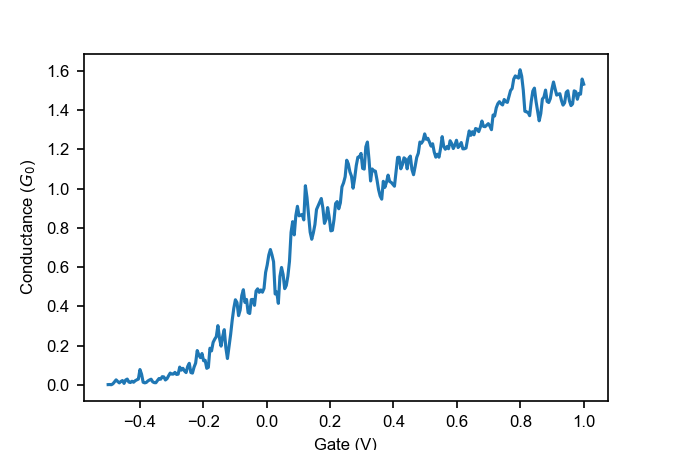

setting mdac in safe mode
Done
Starting experimental run with id: 2
setting mdac in safe mode
Done


Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 132, in run
    self._loop()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 163, in _loop
    self._call_callback_on_queue_data()
  File "d:\code\qcodes\qcodes\dataset\data_set.py", line 146, in _call_callback_on_queue_data
    self.callback(result_list, self._data_set_len, self.state)
  File "D:\Code\v2_dataset_tools\experiments\realtime_monitors.py", line 54, in __call__
    xnew, ynew = [r[i] for i in [self.x_index, self.y_index]]
  File "D:\Code\v2_dataset_tools\experiments\realtime_monitors.py", line 54, in <listcomp>
    xnew, ynew = [r[i] for i in [self.x_index, self.y_index]]
IndexError: list index out of range



IndexError: list index out of range

In [46]:

def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(1)
    lockin_dc(0e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    sr1.time_constant(.1)
    #ami_x.field(0)
    time.sleep(1)
    ami_x.ramp_rate(0.001) # T/s

    # Field setting and ramping should now be done automagically in the field_window function
    #ami_x.ramp_to(0) # unit: T. non-blocking
#     ami_x.ramp_to(0.4) # unit: T. non-blocking

def cleanup(): 
    #pass
    ami_x.field(ami_x.field()) # stops the non-blocking field ramp
    sr1.amplitude(0)
    lockin_dc(0)
    set_mdac_in_safemode()
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_z.field(0)

# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

@getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T')])
def measure_acdc(gain=1e6, Rseries=13.4e3, adder_atten=1e-2):
    time.sleep(0.02) 
    B_x = ami_x.field()
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    #V_meas = key2.volt()
    #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        #time.sleep(3)
        #print(sr1.X())
    Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = sr1.R()
    L1Y     = sr1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = sr1.X()
    current_ac = L1X/gain    
    g       = 12906.4/(Vac/current_ac - Rseries) #[2e^2/h]
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
    return result

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_A5A10_pinchoff_0mVbias",
    [(setup, ())],
    nest(       
        #sweep(ami_x.field, np.linspace(0, 1, 5001)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, smart_linspace(0, 1, 4200, ami_x.field, 0.06, 0.16, 0.0025)),
        #sweep(field_sweep, field_window(ami_x, -1, 1)),
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(1,-0.5, 300)),
        #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_acdc
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    #live_plot_axes=[{"$B_x$ (T)": 9, "Conductance ($G_0$)": 3}]
    live_plot_axes=[{"Gate (V)": 0, "Conductance ($G_0$)": 3}]
)

## Zig zag sweeping $B$ at various gates

3.46150108335e-06


<IPython.core.display.Javascript object>


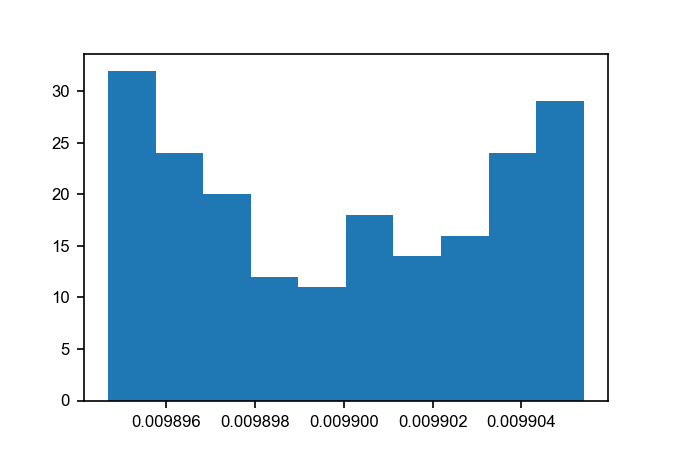

(array([ 32.,  24.,  20.,  12.,  11.,  18.,  14.,  16.,  24.,  29.]),
 array([ 0.0098947 ,  0.00989577,  0.00989684,  0.00989791,  0.00989898,
         0.00990005,  0.00990112,  0.00990219,  0.00990326,  0.00990433,
         0.0099054 ]),
 <a list of 10 Patch objects>)

In [119]:
s = np.empty(200)
for i in range(200):
    s[i] = ami_x.field()
print(s.std())
plt.figure('field std')
plt.hist(s)

In [74]:
set_mdac_in_safemode()
sr1.amplitude(0)
sr1.sine_outdc(0)
sr2.amplitude(0)
sr2.sine_outdc(0)
#ivvi.set_dacs_zero()
key1.write('ABOR')
key2.write('ABOR')
ami_x.ramp_to(0)

setting mdac in safe mode
Done


In [55]:
#set_mdac_in_safemode()
initialize(source, gate)
sr1.amplitude(2e-3)
sr1.phase(0)

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # take continuous measurements
key1.write('INIT'); # start

for sweep_counter, gate_step in enumerate(np.array([[x]*2 for x in [0.29, 0.31, 0.32]]).reshape(-1).tolist()):
    def setup():
        #set_mdac_in_safemode()
        #initialize(source, gate)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(gate_step)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        sr1.time_constant(.1)
        #ami_x.field(0)
        ami_x.ramp_rate(0.0005)
        time.sleep(1)
        #if sweep_counter % 2 == 0: # first time (counter==0)
        #    ami_x.ramp_to(1) # non-blocking
        #else:
        #    ami_x.ramp_to(0)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)
    
    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps = 1E-5, init_to_closest_lim = True):

        val = magnet.field;
        
        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        #eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);
        #eps = 1e-5
        
        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:           

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);
            
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val
    
    @getter([('current', 'A'), ('raw_voltage_dc', 'V'),('conductance', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'), ('B_x', 'T')])
    def measure_acdc(gain=1e6, Rseries=18.4e3, adder_atten=1e-2):
        time.sleep(0.04) 
        B_x = ami_x.field()
        key_raw = float(key1.ask('DATA:LAST?').split(' ')[0]) # 8.36 ms ± 166 µs per loop
        current_dc = -key_raw/gain
        #V_meas = key2.volt()
        #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            #time.sleep(3)
            #print(sr1.X())
        Vac     = adder_atten*sr1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        #L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        #L1R     = sr1.R()
        #L1Y     = sr1.Y()
        L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
        L1R = (L1X**2 + L1Y**2)**.5 # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        current_ac = L1X/gain    
        g       = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_B15B13_ring_AB_stability_test_"+str(gate_step)+"gate_0bias_0T_to_1T_temp_1100mK_sweep"+str(sweep_counter),#gate="+str(0.4 + sweep_counter*0.02),
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(time_sweep, np.linspace(0, 1, 4200)),  # make sure this takes longer than the field ramp
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            sweep(field_sweep, field_window(ami_x, 0, 1)),
            #sweep(mdac_gate_voltage, gate_values),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure_acdc
        ),
        [(cleanup, ())], 
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=None #[{"$B_x$ (T)": 9, "Conductance ($G_0$)": 3}]
    )
                       
    time.sleep(10)

#set_mdac_in_safemode()
sr1.amplitude(0)
#sr1.sine_outdc(0)
key1.write('ABOR'); # Stop Keysight measurements

Starting experimental run with id: 144
Initializing (blocking) field to 0 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.29gate_0bias_0T_to_1T_temp_1100mK_sweep0/0
Starting experimental run with id: 145
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to 0 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.29gate_0bias_0T_to_1T_temp_1100mK_sweep1/0
Starting experimental run with id: 146
Initializing (blocking) field to 0 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.31gate_0bias_0T_to_1T_temp_1100mK_sweep2/0
Starting experimental run with id: 147
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to 0 T ...
Completed measurement. Database path: Q169_B15B13_ring_AB_stability_test_0.31gate_0bias_0T_to_1T_temp_1100mK_sweep3/0
Starting experimental run with id: 148
Initi

### Dual wire mobility, gate and field sweep

In [ ]:
#set_mdac_in_safemode()
initialize(source, gate)
sr1.amplitude(2e-3)
sr1.phase(0)
sr2.amplitude(2e-3)
sr2.phase(0)

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # take continuous measurements
key1.write('INIT'); # start

key2.write('CONF:VOLT:DC 1,1E-6'); # config 1 V range and 1 uV resolution
key2.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, will adjust resolution ^ as per device manual
key2.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key2.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key2.write('TRIG:COUN INF'); # take continuous measurements
key2.write('INIT'); # start

for sweep_counter, gate_step in enumerate([round(x, 1) for x in np.linspace(-0.3, 1.5, 19).tolist()]):
    def setup():
        #set_mdac_in_safemode()
        #initialize(source, gate)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(gate_step)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #sr1.amplitude(2e-3)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        sr1.time_constant(.1)
        sr2.time_constant(.1)
        #ami_x.field(0)
        ami_x.ramp_rate(0.0005)
        time.sleep(1)
        #if sweep_counter % 2 == 0: # first time (counter==0)
        #    ami_x.ramp_to(1) # non-blocking
        #else:
        #    ami_x.ramp_to(0)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps = 1E-5, init_to_closest_lim = True):

        val = magnet.field;

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        #eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);
        #eps = 1e-5

        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:           

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);

        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val

    @getter([('current_1', 'A'), ('current_2', 'A'), ('raw_voltage_dc_1', 'V'), ('raw_voltage_dc_2', 'V'), ('conductance_1', '2e^2/h'), ('conductance_2', '2e^2/h'), ('Lockin1_X', 'V'), ('Lockin2_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin2_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin2_R', 'V'), ('Lockin1_phase', 'deg'), ('Lockin2_phase', 'deg'), ('Lockin1_excitation', 'V'), ('Lockin2_excitation', 'V'), ('B_x', 'T')])
    def measure_acdc(gain=1e6, Rseries_1=13.4E3, Rseries_2=13.4E3, adder_atten=1e-2):
        time.sleep(0.04) 
        B_x = ami_x.field()
        key1_raw = float(key1.ask('DATA:LAST?').split(' ')[0]); # 8.36 ms ± 166 µs per loop
        key2_raw = float(key1.ask('DATA:LAST?').split(' ')[0]);
        current_dc_1 = -key1_raw / gain;
        current_dc_2 = -key2_raw / gain;
        #V_meas = key2.volt()
        #if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            #time.sleep(3)
            #print(sr1.X())
        Vac_1     = adder_atten * sr1.amplitude()  #*np.sqrt(2)
        Vac_2     = adder_atten * sr2.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        #L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        #L1R     = sr1.R()
        #L1Y     = sr1.Y()
        L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
        L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
        L1R = (L1X**2 + L1Y**2)**.5; # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
        L2R = (L2X**2 + L2Y**2)**.5;
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        current_ac_1 = L1X / gain;
        current_ac_2 = L2X / gain;
        g_1       = 12906 / (Vac_1 / current_ac_1 - Rseries_1) #[2e^2/h]
        g_2       = 12906 / (Vac_2 / current_ac_2 - Rseries_2) #[2e^2/h]
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = current_dc_1, current_dc_2, key1_raw, key2_raw, g_1, g_2, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Vac_1, Vac_2, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_dual_wire_(1)_C15C16_(2)_A19A21_"+str(gate_step)+"gate_0bias_-1T_to_1T_sweep"+str(sweep_counter),
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(time_sweep, np.linspace(0, 1, 4200)),  # make sure this takes longer than the field ramp
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            sweep(field_sweep, field_window(ami_x, -1, 1)),
            #sweep(mdac_gate_voltage, gate_values),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure_acdc
        ),
        [(cleanup, ())], 
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=None #[{"$B_x$ (T)": 9, "Conductance ($G_0$)": 3}]
    )

set_mdac_in_safemode();
sr1.amplitude(0);
sr2.amplitude(0);
key1.write('ABOR');
key2.write('ABOR');
ami_x.ramp_to(0);

Starting experimental run with id: 155
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_C15C16_(2)_A19A21_-0.3gate_0bias_-1T_to_1T_sweep0/0
Starting experimental run with id: 156
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_C15C16_(2)_A19A21_-0.2gate_0bias_-1T_to_1T_sweep1/0
Starting experimental run with id: 157
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_C15C16_(2)_A19A21_-0.1gate_0bias_-1T_to_1T_sweep2/0
Starting experimental run with id: 158
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_dual_wire_(1)_C15C16_(2)_A19A21_0.0gate_0bias_-1T_to_1T_sweep3/0
Starting experimental run with id: 159
Initializing (blocking) field to -1 T 

## Current bias measurements

In [171]:
sr1.frequency(19.13)

In [167]:
source = mdac.ch58
gate = mdac.ch09

In [172]:
def setup():
    set_mdac_in_safemode()
    initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_gate_voltage(0)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(19.31) 
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(1)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    sr1.amplitude(0)
    #sr1.sine_outdc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter([('dc_voltage1', 'V'), ('dc_voltage2', 'V'), ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'), \
         ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),\
         ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), \
         ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'), \
         ('Lockin1_excitation', 'A')])
def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
    time.sleep(0.05)
    #B_x = ami_x.field()
    key1_raw = key1.volt()
    voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
    key2_raw = key2.volt()
    voltage2_dc = -key2_raw/100
    #V_meas = key2.volt()
    Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R, L2R     = sr1.R(), sr2.R()
    L1Y, L2Y     = sr1.Y(), sr2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X, L2X     = sr1.X(), sr2.X()
    voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
    g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
    R_hall = voltage2_ac / Iac
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac
    return result

#gate_values = np.linspace(0, -0.1, 51)
#gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_B2B5_Ibias_pinchoff",
    [(setup, ())],
    nest(       
        #sweep(ami_x.field, np.linspace(1, -1, 201)),
        #sweep(sr1.frequency, np.linspace(1,141,141)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(time_sweep, np.linspace(0, 1, 201)), 
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        sweep(mdac_gate_voltage, np.linspace(1.5, 0, 301)),
        #sweep(lockin_dc, np.linspace(15e-3, -15e-3, 201)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        measure_i_bias
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=None
)

setting mdac in safe mode
Done
Starting experimental run with id: 114
setting mdac in safe mode
Done
Completed measurement. Database path: Q169_B2B5_Ibias_pinchoff/1


In [ ]:
# field ramp
set_mdac_in_safemode()
initialize(source, gate)

for mdgv in np.linspace(0, 1.5, 31):

    def setup():
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        #key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_gate_voltage(mdgv)
        #lockin_dc(10e-3)
        #gate.voltage(0.8)
        #key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(31.296) 
        #sr1.phase(0)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_x.ramp_to(-0.2)
        time.sleep(1)

    def cleanup(): 
        pass
        #sr1.amplitude(0)
        #sr1.sine_outdc(0)
        #set_mdac_in_safemode()   
        #mdac_voltage(0)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)


    # Basically converts callable function to generator
    def get_next(val):
        while 1:
            yield val();

    # Generate linspace points until val() is outside of window        
    def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
        linspace = np.linspace(start, stop, step)
        for value in linspace:

            if val() < (lowlim - eps) or val() > (highlim + eps):
                break

            yield value

    # Sweep the field as long as val() is within the window
    def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

        val = magnet.field;

        # To correct for overshoot since the last window sweep of size eps, sweep field back to either
        # lowlim or highlim, whichever the current field value is closest to, then begin
        if init_to_closest_lim:

            lowlim_diff = np.abs(val() - lowlim);
            highlim_diff = np.abs(val() - highlim);

            if lowlim_diff < highlim_diff:
                initlim = lowlim;
                finlim = highlim;
            else:
                initlim = highlim;
                finlim = lowlim;

            eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

            print('Initializing (blocking) field to {} T ...'.format(initlim))
            magnet.field(initlim);
            print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
            magnet.ramp_to(finlim + eps);

        for field_val in get_next(val):
            if np.abs(field_val - finlim) < np.abs(eps):
                    break

            yield field_val

    @getter([('dc_voltage1', 'V'), ('dc_voltage2', 'V'), ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'), \
             ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),\
             ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), \
             ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'), \
             ('Lockin1_excitation', 'A'), ('B_x', 'T')])
    def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
        time.sleep(0.1)
        B_x = ami_x.field()
        key1_raw = key1.volt()
        voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
        key2_raw = key2.volt()
        voltage2_dc = -key2_raw/100
        #V_meas = key2.volt()
        Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        L1R, L2R     = sr1.R(), sr2.R()
        L1Y, L2Y     = sr1.Y(), sr2.Y()
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        L1X, L2X     = sr1.X(), sr2.X()
        voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
        g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
        R_hall = voltage2_ac / Iac
        #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
        result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac, B_x
        return result

    result = do_experiment(
    #     "NIS-Thermometer/SIM_10k",
        "Q169_B2B5_Ibias_field_ramp_vs_gate_Vg={:.2f}V".format(mdgv),
        [(setup, ())],
        nest(       
            #sweep(ami_x.field, np.linspace(0, 1, 5001)),
            #sweep(sr1.frequency, np.linspace(80,130,41)),
            #sweep(gate.voltage, np.linspace(0, -3, 61)),
            #sweep(mdac_gate_voltage, np.linspace(0, 1, 101)),
            #sweep(time_sweep, smart_linspace(0, 1, 4200, ami_x.field, 0.06, 0.16, 0.0025)),
            sweep(field_sweep, field_window(ami_x, -1, 1)),
            #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
            #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
            #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
            #sweep(mdac_gate_voltage, gate_points),
            measure_i_bias
        ),
        [(cleanup, ())], 
        return_format=["data_set_path", "dataset"], 
        live_plot_axes=None
    )

sr1.amplitude(0)
mdac_gate_voltage(0.3)

setting mdac in safe mode
Done
Starting experimental run with id: 115
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.00V/0
Starting experimental run with id: 116
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.05V/0
Starting experimental run with id: 117
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.10V/0
Starting experimental run with id: 118
Initializing (blocking) field to 1 T ...
Sweeping (non-blocking) field to -1 T ...
Completed measurement. Database path: Q169_B2B5_Ibias_field_ramp_vs_gate_Vg=0.15V/0
Starting experimental run with id: 119
Initializing (blocking) field to -1 T ...
Sweeping (non-blocking) field to 1 T ...
Completed measurement. 

## field_window quickfix test
Workaround for generator running out of yields and stopping the measurement code after only one iteration

Will store fresh field_window generator as first element in list called field_win

This element is then updated with a new instance of the field_window generator upon completion of iteration,
allowing for a fresh sweep to start the next iteration

In [34]:
# field ramp

def setup():
    #set_mdac_in_safemode()
    #initialize(source, gate)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    #key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    #mdac_gate_voltage(0)
    #lockin_dc(10e-3)
    #gate.voltage(0.8)
    #key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #sr1.amplitude(1)     # 1e-2 RF attenuator, then 1e-2 IVVI attenuator, then 1e-5 A/V I-source, so 1V -> 1nA
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
#     sr1.frequency(31.296) 
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(1)

def cleanup(): 
    #pass
    #sr1.amplitude(0)
    lockin_dc(0)
    set_mdac_in_safemode()   
    #mdac_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    

# Basically converts callable function to generator
def get_next(val):
    while 1:
        yield val();

# Generate linspace points until val() is outside of window        
def smart_linspace(start, stop, step, val, lowlim, highlim, eps): 
    linspace = np.linspace(start, stop, step)
    for value in linspace:

        if val() < (lowlim - eps) or val() > (highlim + eps):
            break

        yield value

# Sweep the field as long as val() is within the window
def field_window(magnet, lowlim, highlim, eps_multi = 0.01, init_to_closest_lim = True):

    val = magnet.field;

    # To correct for overshoot since the last window sweep of size eps, sweep field back to either
    # lowlim or highlim, whichever the current field value is closest to, then begin
    if init_to_closest_lim:

        lowlim_diff = np.abs(val() - lowlim);
        highlim_diff = np.abs(val() - highlim);

        if lowlim_diff < highlim_diff:
            initlim = lowlim;
            finlim = highlim;
        else:
            initlim = highlim;
            finlim = lowlim;

        eps = finlim * eps_multi * (-1 if finlim == lowlim else 1);

        print('Initializing (blocking) field to {} T ...'.format(initlim))
        magnet.field(initlim);
        print('Sweeping (non-blocking) field to {} T ...'.format(finlim))
        magnet.ramp_to(finlim + eps);

    for field_val in get_next(val):
        if np.abs(field_val - finlim) < np.abs(eps):
                break

        yield field_val

def renew_generator(gen, store, args):
    store[0] = gen(*args);
        
@getter([('dc_voltage1', 'V'), ('dc_voltage2', 'V'), ('raw_voltage_DMM1', 'V'), ('raw_voltage_DMM2', 'V'), \
         ('R_xx', 'h/2e^2'), ('R_xy', 'Ohm'),\
         ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'), ('Lockin1_phase', 'deg'), \
         ('Lockin2_X', 'V'), ('Lockin2_Y', 'V'), ('Lockin2_R', 'V'), ('Lockin2_phase', 'deg'), \
         ('Lockin1_excitation', 'A'), ('B_x', 'T')])
def measure_i_bias(gain1=1e3, gain2=1e3, source_atten=1e-9):
    time.sleep(0.05)
    B_x = ami_x.field()
    key1_raw = key1.volt()
    voltage1_dc = -key1_raw/100  # the dc gain is always 100 when V-meas is set to ac coupling
    key2_raw = key2.volt()
    voltage2_dc = -key2_raw/100
    #V_meas = key2.volt()
    Iac     = source_atten*sr1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R, L2R     = sr1.R(), sr2.R()
    L1Y, L2Y     = sr1.Y(), sr2.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X, L2X     = sr1.X(), sr2.X()
    voltage1_ac, voltage2_ac = L1X/gain1, L2X/gain2
    g       = voltage1_ac/Iac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
    R_hall = voltage2_ac / Iac
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = voltage1_dc, voltage2_dc, key1_raw, key2_raw, g, R_hall, L1X, L1Y, L1R, L1P, L2X, L2Y, L2R, L2P, Iac, B_x
    return result

# Workaround for generator running out of yields and stopping the measurement code after only one iteration
# Will store fresh field_window generator as first element in list called field_win
# This element is then updated with a new instance of the field_window generator upon completion of iteration,
# allowing for a fresh sweep to start the next iteration
field_window_args = [ami_x, -0.95, -1];
field_win = [None];
renew_generator(field_window, field_win, field_window_args);

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "Q169_field_ramp_regeneration_test",
    [(setup, ())],
    nest(       
        #sweep(ami_x.field, np.linspace(0, 1, 5001)),
        #sweep(sr1.frequency, np.linspace(80,130,41)),
        #sweep(gate.voltage, np.linspace(0, -3, 61)),
        #sweep(mdac_gate_voltage, np.linspace(0, 1, 101)),
        sweep(time_sweep, np.linspace(0,1,5)),
        sweep(field_sweep, field_win[0]),
        #sweep(sr1.sine_outdc, np.linspace(5e-3, -5e-3, 100)),
        #sweep(lockin_dc, np.linspace(10e-3, -10e-3, 51)), # real voltage applied onto device
        #sweep(mdac_bias_voltage, np.linspace(-15e-3, 15e-3, 301)),
        #sweep(mdac_gate_voltage, gate_points),
        renew_generator(field_window, field_win, field_window_args),
        measure_i_bias
    ),
    [(cleanup, ())], 
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"$B_x$ (T)": 17, "R_xx ($h/2e^2$)": 6}]
)

ValueError: ('Do not know how to wrap instance of ', <class 'NoneType'>)

## Miscellaneous/debugging 

In [ ]:
ramp(sr1.sine_outdc, 0, bias_ramp_stepsize, bias_ramp_delay)

In [54]:
%%timeit
B_x = ami_x.field()

108 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
initialize(source,gate)

In [87]:
mdac_gate_voltage(0.3)

{'mdac_gate_voltage': 0.29999999999999999}

In [22]:
mdac_gate_voltage(0)

NameError: name 'mdac_gate_voltage' is not defined

In [61]:
sr2.amplitude(2e-3);

In [ ]:
r1 = mdac.ch58
r2 = mdac.ch62

In [ ]:
r2.dac_output('close')
r2.smc('close')

In [ ]:
r2.voltage(1e-3)

In [ ]:
r1.voltage(0)
r1.dac_output('open')
r1.smc('open')

In [ ]:
mdac.ch58.dac_output('close')
mdac.ch58.smc('close')

In [ ]:
mdac.ch58.divider()

In [77]:
initialize(source, gate)

In [ ]:
ami_z.ramp_to(5)

In [114]:
%%timeit
#B_x = ami_x.field()
key1_raw, key2_raw = key1.volt(), key2.volt()
voltage1_dc, voltage2_dc = -key1_raw/100, -key2_raw/100
Iac     = 1e-2*sr1.amplitude()  #*np.sqrt(2)
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
L1R, L2R = np.sqrt(np.power(L1X,2)+np.power(L1Y,2)), np.sqrt(np.power(L2X,2)+np.power(L2Y,2))
voltage1_ac, voltage2_ac = L1X/100, L2X/100
g       = voltage1_ac / 12906.4 #[h/2e^2], using lockin1 for R_xx and lockin2 for R_xy
R_hall = voltage2_ac 

VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'READ?' to <Keysight_34465A: key1>", 'getting key1_volt')

In [13]:
%%timeit
# sr1.ask('SNAPD?')
# sr2.ask('SNAPD?')

# testing on 28/08/2018: this takes 35ms to execute
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L2X, L2Y, L2P = sr2.get_values('X', 'Y', 'P')
L1R, L2R = np.sqrt(np.power(L1X,2)+np.power(L1Y,2)), np.sqrt(np.power(L2X,2)+np.power(L2Y,2))

# testing on 28/08/2018: this takes 95ms to execute
# L1P, L2P     = sr1.P(), sr2.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
# L1R, L2R     = sr1.R(), sr2.R()
# L1Y, L2Y     = sr1.Y(), sr2.Y()
# # the above lines (excluding time.sleep) take at least 75ms to execute. 
# L1X, L2X     = sr1.X(), sr2.X()

34.7 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
sr1.ask('CDSP? 2')

'8'

In [71]:
sr1.input_range()

1

In [1]:
%%timeit
#key2v = key2.volt()
key1v = key1.volt()

NameError: name 'key1' is not defined

In [125]:
gate.voltage()

0.5000042

In [ ]:
key1v = key1.volt

In [20]:
%%timeit
key1_raw, key2_raw = key1.volt(), key2.volt()

155 ms ± 8.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
mdac_gate_voltage(0)

{'mdac_gate_voltage': 0}

In [115]:
%%timeit
key1.get_idn()
key2.get_idn()

51 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Keysight continuous measurement

<IPython.core.display.Javascript object>


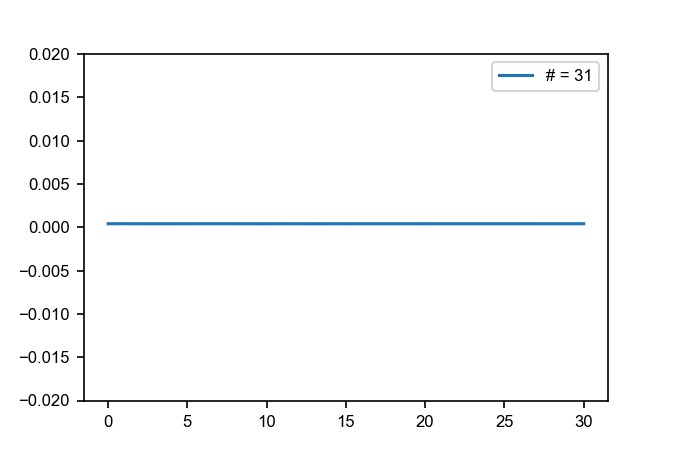

KeyboardInterrupt: 

In [66]:
#%%timeit

# Setup DMM for continuous measurements
key1.write('CONF:VOLT:DC 0.1,1E-6'); # config 100 mV range
key1.write('SENS:VOLT:DC:NPLC 1'); # set NPLC, capture rate seems 2x faster when also setting resolution ^
key1.write('TRIG:DEL MIN'); # MIN = 1 us, minimum delay after trigger received as meas started
key1.write('TRIG:SOUR IMM'); # trigger signal always present, immediate triggering
key1.write('TRIG:COUN INF'); # do not stop measuring once the immediate trigger is hit

key1.write('INIT'); # start
time.sleep(1); # allow it time to setup and measure a few first points

fig = plt.figure('key');
fpl = fig.add_subplot(1, 1, 1);

while True:
    
    key1_data = key1.ask('R?'); # get all logged data
    key1_data = key1_data[2 + int(key1_data[1]):]; # remove header info
       
    key1_volts = [float(x) for x in key1_data.split(',')]; # convert to floating point list
    
    fpl.clear();
    fpl.plot(range(len(key1_volts)), key1_volts);
    plt.ylim([-20E-3, 20E-3]);
    plt.legend(['# = ' + str(len(key1_volts))]);
    fig.canvas.draw();
    
    time.sleep(0.5);

In [74]:
# Performance test
%timeit float(key1.ask('DATA:LAST?').split(' ')[0])

8.36 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
%timeit np.sqrt(np.power(3.3478, 2) + np.power(3.38974, 2))
%timeit (3.3478**2 + 3.38974**2)**.5

6.26 µs ± 98.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
23.3 ns ± 0.0317 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [107]:
%%timeit
time.sleep(0.02) 
B_x = ami_x.field()
key_raw = float(key1.ask('DATA:LAST?').split(' ')[0]) # 8.36 ms ± 166 µs per loop
current_dc = -key_raw/1E6
#V_meas = key2.volt()
#if np.abs(np.abs(sr1.sine_outdc())-0.05) < 18e-3: # make this range larger than distance btw two points
    #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
    #time.sleep(3)
    #print(sr1.X())
Vac     = 100*sr1.amplitude()  #*np.sqrt(2)
#SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
#L1P     = sr1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
#L1R     = sr1.R()
#L1Y     = sr1.Y()
L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')
L1R = (L1X**2 + L1Y**2)**.5 # Using native Python syntax is 300x faster than numpy 23.3 ns ± 0.0317 ns per loop
# the above lines (excluding time.sleep) take at least 75ms to execute. 
current_ac = L1X/1E6  
g       = 12906/(Vac/current_ac - 18.3E3) #[2e^2/h]
#result  = current_dc, key_raw, g, L1X, L1Y, V_meas
result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac, B_x

111 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%timeit L1X, L1Y, L1P = sr1.get_values('X', 'Y', 'P')

15.7 ms ± 60.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
